In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor

np.random.seed(42)

# Sample size
n = 100

# SCM: latent ability/confounder
U = np.random.normal(0, 1, n)

# Observed proxy for U (backdoor)
Z = U + np.random.normal(0, 0.1, n)

# Study hours X depends on confounder Z
X = 2 + 1.5 * Z + np.random.normal(0, 0.5, n)

# Exam score Y depends on X and U (true causal effect)
Y = 50 + 5*X + 3*U + np.random.normal(0, 2, n)

# Combine into a DataFrame
data = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})
data.head()


,X,Y,Z
0,2.711659,63.390449,0.355177
1,2.009899,58.514340,-0.180329
2,3.461651,70.745909,0.613417
3,4.691104,79.245351,1.442802
4,0.935742,53.934449,-0.250282


In [2]:
# kNN regression for backdoor adjustment
k = 5
knn = KNeighborsRegressor(n_neighbors=k)

# Features: X and Z
X_features = data[['X', 'Z']]
y_target = data['Y']

# Fit kNN
knn.fit(X_features, y_target)


KNeighborsRegressor()

In [8]:
# Target intervention
x_do = 4.0

# Predict for each observed Z under X=x_do
X_do = np.column_stack([np.full(n, x_do), data['Z'].values])
Y_hat = knn.predict(X_do)

# Backdoor-adjusted estimate
EY_do = Y_hat.mean()
print(f"Estimated E[Y | do(X={x_do})] = {EY_do:.2f}")


Estimated E[Y | do(X=4.0)] = 69.28


/Library/Python/3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [9]:
# Naïve kNN ignoring Z
knn_naive = KNeighborsRegressor(n_neighbors=k)
knn_naive.fit(data[['X']], y_target)

EY_naive = knn_naive.predict([[x_do]])[0]
print(f"Naive estimate E[Y | X={x_do}] = {EY_naive:.2f}")


Naive estimate E[Y | X=4.0] = 72.15


/Library/Python/3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


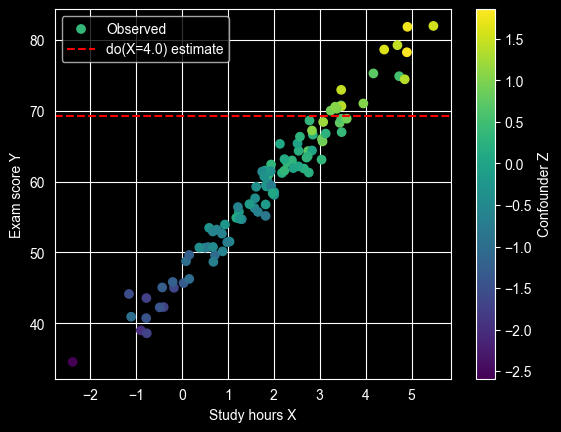

In [10]:
import matplotlib.pyplot as plt

# Plot data
plt.scatter(data['X'], data['Y'], c=data['Z'], cmap='viridis', label='Observed')
plt.colorbar(label='Confounder Z')
plt.axhline(EY_do, color='red', linestyle='--', label=f'do(X={x_do}) estimate')
plt.xlabel('Study hours X')
plt.ylabel('Exam score Y')
plt.legend()
plt.show()
